# Liver Model Construction: Notebook-Glycolysis ONLY-trial

## Setup workflow

### Import packages

In [1]:
import os
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import sympy as sy
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
mass_config = MassConfiguration()

mass_config.irreversible_Keq = float("inf")

print("MASSpy version: {0}".format(mass.__version__))

import pandas as pd

from six import iteritems

import sympy as sym

import matplotlib.pyplot as plt

from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

MASSpy version: 0.1.1


In [ ]:
pip install cplex

In [2]:
seed = int(4)
n_models = 5

mass_config = MassConfiguration()
mass_config.solver = "cplex"

## Set paths and constants

### Directory paths

In [3]:
#had to remove the mass
model_dir = os.path.abspath("../models")
maps_dir = os.path.abspath("../maps")

# Create MASS model from COBRA model

### Load COBRA model

In [4]:
core_model=load_json_cobra_model(filename=os.path.join(model_dir,"CoreModel.json"))
core_model

Name,None
Memory address,0x0238fb0c28b0
Number of metabolites,178
Number of reactions,187
Number of groups,0
Objective expression,1.0*ATPM - 1.0*ATPM_reverse_5b752
Compartments,"m, i, c, r,"


In [5]:
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    #df = df.drop("Fasting Time", axis=1)
    #df = df.drop("Additional Notes", axis=1)
    #df = df.drop("Flux (mmol/(L*hr))", axis=1)
    #df = df.drop("Name", axis=1)
    return df

In [6]:
flux_df = load_data(
    filepath='1.3-ma-data-collection.xlsx',
    sheet_name="Fluxes")
flux_df = flux_df.drop("Fasting Time", axis=1)
flux_df = flux_df.drop("Additional Notes", axis=1)
flux_df = flux_df.drop("Flux (mmol/(L*hr))", axis=1)
flux_df


,Flux(mmol/(gDW*hr))
ID,
GLCter,-0.001674
G6PPer,0.001674
G6Pter,0.001674
GLPASE1,0.000215
PGMT,0.000215
EX_glygn2_c,-0.000215
GAPD,0.002903
PGK,-0.002903
PGM,0.002903


In [7]:
v_vars = []
v_data = []

In [8]:
for rid, flux in flux_df.itertuples():
    reaction = core_model.reactions.get_by_id(rid)
    #reaction.bounds = (flux, flux)
    
    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)
    
#print(v_vars)
#print(v_data)

In [9]:
# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)
F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
core_model.objective = objective[0]
core_model.objective_direction = "min"

flux_solution = core_model.optimize()

In [10]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
flux_solution
type(flux_solution)

cobra.core.solution.Solution

In [11]:
flux_solution.fluxes


CSm                1.376013e-03
ACONTm             6.879177e-04
ICDHxm             6.879177e-04
AKGDm              6.879177e-04
SUCOASm           -6.879177e-04
SUCD1m             6.879177e-04
FUMm               6.879177e-04
MDHm               4.293410e-03
NADH2_u10mi        3.783636e-03
FADH2ETC           6.879177e-04
CYOR_u10mi         4.471554e-03
CYOOm2i            2.235777e-03
ATPS4mi            7.979419e-03
Htmi               0.000000e+00
HEX1               2.580381e-03
PGI                1.004542e-03
PFK                1.004542e-03
FBA                1.004542e-03
TPI                1.004542e-03
GAPD               2.009083e-03
PGK               -2.009083e-03
PGM                1.252539e-03
ENO               -1.252539e-03
PYK                1.662012e-03
ADK1               6.880957e-04
PDHm               1.376013e-03
LDH_L             -6.330700e-04
G6PDH2r            0.000000e+00
PGL                0.000000e+00
GND                0.000000e+00
RPI                0.000000e+00
RPE     

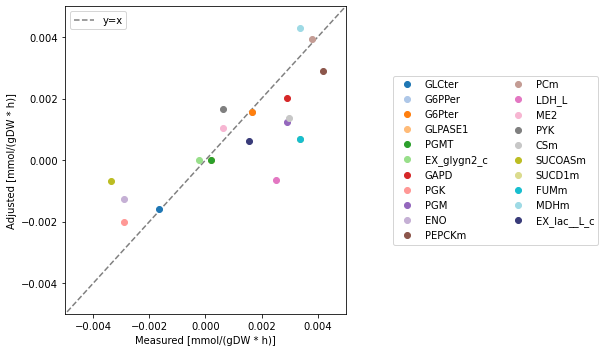

In [12]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_df["Flux(mmol/(gDW*hr))"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.005,0.005), ylim=(-0.005, 0.005),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()
#check directionality 


## Create MASS model

In [13]:
glycolysis = MassModel("Glycolysis", array_type='DataFrame', dtype=np.int64)
glycolysis

Name,Glycolysis
Memory address,0x023895755670
Stoichiometric Matrix,0x0
Matrix Rank,0
Number of metabolites,0
Initial conditions defined,0/0
Number of reactions,0
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Define reactions

In [14]:
reaction_list = ['HEX1',
                'PGI',
                'FBP',
                'PFK',
                'FBA',
                'TPI',
                'GAPD',
                'PGK',
                'PGM',
                'ENO',
                'PEPtm',
                'PEPCKm',
                'LDH_L',
                'PYK',
                'PCm',
                'PYRt2m']




In [15]:


# Convert cobra.Reactions to mass.MassReactions
for rid in reaction_list:
    reaction = core_model.reactions.get_by_id(rid)
    glycolysis.add_reactions([MassReaction(reaction)])
    
## set possible exchanges for in and out?


##  Set Fluxes

In [16]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = glycolysis.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 # mmol/gdW*hr --> mmol/L * hr 
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 3.2992884001222023
v_PGI: 1.2844120883040366
v_FBP: 0.0
v_PFK: 1.2844120883040366
v_FBA: 1.2844120883040366
v_TPI: 1.2844120883040366
v_GAPD: 2.5688241766080733
v_PGK: -2.5688241766080733
v_PGM: 1.6015026930233986
v_ENO: -1.6015026930233986
v_PEPtm: 3.726559657680128
v_PEPCKm: 3.726559657680128
v_LDH_L: -0.8094464970104237
v_PYK: 2.12505696465673
v_PCm: 5.046263621587324
v_PYRt2m: 6.805641301184972


## Set Keqs

In [17]:
# Load equilibrium constants
Keq_df = pd.read_excel(
    io='1.3-ma-data-collection.xlsx',
    sheet_name="Keqs",
    index_col=0).drop("Reference", axis=1).drop("Stoichiometry", axis=1)

Keq_df

,Equlibrium Constant
Reaction,
CSm,2.900000e-07
ACONTm,1.000000e-01
ICDHxm,1.000000e-01
AKGDm,7.100000e+04
SUCOASm,1.600000e+00
SUCD1m,NaN
FUMm,4.000000e+00
MDHm,1.500000e-05
NADH2_u10mi,NaN


In [18]:

# Set equilibrium constants
Keq_list =[]
for rid, Keq in Keq_df.itertuples():
    if rid in reaction_list: 
        reaction = glycolysis.reactions.get_by_id(rid)
        reaction.Keq = Keq
        Keq_list.append(reaction.Keq)
        print("{0}: {1}".format(reaction.Keq_str, Keq))
        

Keq_HEX1: 3000.0
Keq_PGI: 0.3
Keq_PFK: 670.0
Keq_FBA: 0.00014
Keq_TPI: 9.6
Keq_GAPD: 0.6
Keq_PGK: 0.00036
Keq_PGM: 6.2
Keq_ENO: 4.6
Keq_PYK: 37000.0
Keq_LDH_L: 4.4e-05
Keq_PCm: 13.4
Keq_PEPCKm: 0.0045
Keq_FBP: 190.0
Keq_PEPtm: 1.0
Keq_PYRt2m: 1.0


In [19]:
len(reaction_list) == len(Keq_list)

True

## Correct Metabolite Identifiers

## Set H2O/H Constants


In [20]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in ["h2o_c", "h_c",'h_i', 'h_m']:
    metabolite = glycolysis.metabolites.get_by_id(metabolite)
    metabolite.fixed = True


## Obtain Concentrations

In [21]:
#Load Concentration Data
conc_df = load_data(
    filepath='1.3-ma-data-collection.xlsx',
    sheet_name="Concentrations")
#conc_df = conc_df.drop("Name", axis=1)
conc_df = conc_df.drop("Additional Notes", axis=1)

# Fix identifiers in the dataframe
#conc_df.index = [prefix_number_id(mid) for mid in conc_df.index]

In [24]:
conc_df.index

Index(['13dpg_c', '2amac_c', '2pg_c', '3haACP_c', '3hbcoa_m', '3hhcoa_m', '3hhexACP_c', '3hocoa_m', '3hoctACP_c', '3ohcoa_m',
       ...
       'thex2eACP_c', 'thf_c', 'thf_m', 'toct2eACP_c', 'Tyr_ggn_c', 'udp_c', 'udpg_c', 'urea_c', 'utp_c', 'xu5p__D_c'], dtype='object', name='ID', length=179)

In [22]:
#Set Concentrations

metabolite_list = ['glc__D_c',
           'g6p_c',
           'f6p_c',
           'fdp_c',
           'dhap_c',
           'g3p_c',
           '13dpg_c',
           '3pg_c',
            '2pg_c',
            'pep_c',
            'pyr_c',
            'lac__L_c',
           'nad_c',
            'nadh_c',
           'amp_c',
           'adp_c',
            'atp_c',
            'pi_c',
            'h_c',          
            'h2o_c',
            'pep_m',
            'pi_m',
            'co2_m',
            'gdp_m',
            'gtp_m',
            'oaa_m',
            'adp_m',
            'atp_m',
            'h_m',
            'hco3_m',
            'pyr_m',
            'h_i']

m=["amp_c"]
for item in m:
    met = core_model.metabolites.get_by_id(item)
    glycolysis.add_metabolites([MassMetabolite(met)])

In [27]:
met_list = []
for mid, name, conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = glycolysis.metabolites.get_by_id(mid)
        metabolite.name = name
        
        metabolite.ic = conc
        met_list.append(metabolite.ic)
    
    
    
# For "pi_c", "g3p_c", "lac__D_c" use steady state literature concentrations
# Set h_c and h2o_c to 1 
for metabolite in ['h_i', 'h_m',"h_c", "h2o_c"]:
    metabolite = glycolysis.metabolites.get_by_id(metabolite)
    if metabolite.id in ["h_c", "h2o_c"]:
        metabolite.ic = 1
    
for metabolite in glycolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))
    


adp_c: 1.99495195
atp_c: 4.72714598
g6p_c: 0.14
glc__D_c: 10.48280703
h_c: 1
f6p_c: 0.12713765
fdp_c: 0.051470825
h2o_c: 1
pi_c: 6.4
dhap_c: 0.17689737
g3p_c: 0.00878387
13dpg_c: nan
nad_c: 1.82530972
nadh_c: 0.00463542
3pg_c: 0.520630485
2pg_c: 0.110560855
pep_c: 0.31
pep_m: 2.05
pi_m: 0.45
co2_m: nan
gdp_m: nan
gtp_m: nan
oaa_m: 0.03119
lac__L_c: 3.26183772
pyr_c: 0.48
adp_m: 8.0389058
atp_m: 9.19
h_m: nan
hco3_m: nan
pyr_m: 1.34
h_i: nan
amp_c: 0.365


In [43]:
#convert nan values to None Type
excluded_metabolites_list = []
for metabolite in glycolysis.metabolites: 
    if type(metabolite.ic) == None: 
        excluded_metabolites_list.append()
excluded_metabolites_list    

#type(glycolysis.metabolites.pyr_m.ic)


[]

In [39]:
glycolysis.metabolites.h_i.ic

nan

In [27]:
len(metabolite_list) == len(glycolysis.metabolites) == len(met_list)

True

In [44]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    glycolysis,
    excluded_metabolites=['h_i', 'h_m',"h_c", "h2o_c",'13dpg_c','co2_m', 'gdp_m', 'gtp_m', 'hco3_m'],
    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
    fixed_conc_bounds=list(glycolysis.fixed),
    fixed_Keq_bounds=glycolysis.reactions.list_attr("Keq_str"))

conc_solution = conc_solver.optimize()
conc_solution

#FBP flux is 0 --> gives error 

['FBP']


,variables,reduced_costs
adp_c,1.994952,0.000000
atp_c,4.727146,0.000000
g6p_c,0.401594,0.000000
glc__D_c,10.482807,0.000000
f6p_c,0.044322,0.000000
...,...,...
Keq_PEPCKm,0.004500,-11.644152
Keq_LDH_L,0.000044,0.000000
Keq_PYK,37000.000000,0.000000
Keq_PCm,13.400000,0.000000


mass\visualization\visualization_util.py:1269 UserWarning: Ignoring {'utp_c', 'r5p_c', 'coa_m', '3ohcoa_m', 'accoa_c', 'mlthf_m', 'argsuc_c', 'fadh2_m', 'hexACP_c', 'occoa_c', 'udp_c', 'crn_m', 'acald_c', 'ocACP_c', 'glygn1_c', '3php_c', 'nadh_m', 'pi_r', 'cit_c', 'nad_m', 'fad_m', 'citr__L_c', '3ohexACP_c', 'hco3_c', 'focytC_m', 'q10_m', 'succoa_m', 'hco3_m', 'ggn_c', 'succ_m', 'amp_m', 'asp__L_c', 'mlthf_c', '6pgc_c', 'ppi_c', 'orn_c', 'ru5p__D_c', 'fum_m', 'thf_c', 'etoh_c', 'nh4_m', 'thf_m', '3snpyr_c', 'glu__L_c', 'co2_m', 'octa_cons_c', 'v', 'h_i', 'gtp_c', 'crn_c', 'glyc3p_2octa_c', 'ppi_m', 'b2coa_m', '3hhexACP_c', 'glygn2_c', 'cit_m', 'h_c', 'aacoa_m', 'cbp_m', 'so3_c', 'malcoa_c', 'nadp_m', 'gdp_m', '3oocoa_m', '3haACP_c', 'nh4_c', 'dxtrn_c', 'hxcoa_m', 'acetone_c', 'e4p_c', 'o2_m', 'akg_c', '3hocoa_m', 's7p_c', 'h2o_r', 'glyc3p_c', 'asp__L_m', 'but2eACP_c', 'g1p_c', '3sala_c', 'occoa_prod_c', 'f1p_c', 'coa_c', 'hx2coa_m', 'mal__L_c', '3ooctACP_c', 'mal__L_m', 'gly_c', 'glyal

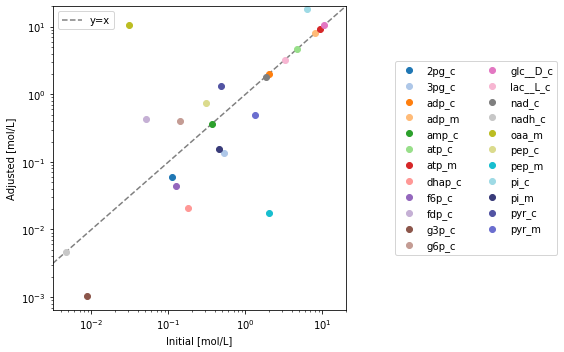

In [45]:
#Compare Results
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration (mM)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(0, 20), ylim=(0, 20), xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    glycolysis, conc_solution, concentrations=True, inplace=True);

## Sample Concentrations


In [46]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycolysis.fixed),
    fixed_Keq_bounds=glycolysis.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = glycolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=seed)
conc_samples.head()

,adp_c,atp_c,g6p_c,glc__D_c,f6p_c,fdp_c,pi_c,dhap_c,g3p_c,nad_c,nadh_c,3pg_c,2pg_c,pep_c,pep_m,pi_m,oaa_m,lac__L_c,pyr_c,adp_m,atp_m,pyr_m,amp_c
0,5.874851,0.780853,1.157255,19.979228,0.012964,0.160880,35.188103,0.065974,0.000106,1.374152,0.001129,0.030224,0.013251,0.165692,0.002991,0.023979,1.806850,8.833416,10.733108,53.621595,5.551267,0.497909,0.172332
1,2.844579,1.075129,0.791591,11.887930,0.015060,0.243821,166.869451,0.035619,0.000297,3.460431,0.037847,0.877341,0.384655,4.809763,0.011707,0.065413,7.071965,2.636786,0.735335,0.921366,4.735491,0.052006,0.083082
2,16.185217,0.577343,2.699279,38.941720,0.255208,1.666340,93.300719,0.091557,0.000859,1.923059,0.034025,0.840476,0.368492,4.607658,0.003853,0.026844,2.327649,11.428814,0.252721,19.058554,12.431990,0.068769,0.058448
3,15.221705,5.770798,0.569846,6.966442,0.007440,0.506730,66.717755,0.089098,0.000258,0.515733,0.001963,0.104938,0.046008,0.575290,0.004243,0.046748,2.563118,13.563892,0.509882,27.004806,14.488948,0.124412,0.115993
4,2.367352,1.513856,0.150306,8.704439,0.004649,0.280569,14.051160,0.014622,0.000446,0.409677,0.000567,0.020399,0.008944,0.111833,0.002851,0.111829,1.722018,1.153238,0.531846,18.195872,33.540104,0.073349,0.080594


## Set concentrations and balance models with pseudoreactions


In [47]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycolysis.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)
        
        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

Number of models in ensemble: 5


In [48]:
models_for_ensemble

[<MassModel Glycolysis_C0 at 0x23895f647f0>,
 <MassModel Glycolysis_C1 at 0x238972c8670>,
 <MassModel Glycolysis_C2 at 0x238973176a0>,
 <MassModel Glycolysis_C3 at 0x2389756a940>,
 <MassModel Glycolysis_C4 at 0x23898735d30>]

## QC/QA

In [49]:
qcqa_model('Glycolysis_C0', parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

AttributeError: 'str' object has no attribute 'reactions'

## Ensure model is in steady state and export

In [50]:
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
tfinal = 1e4
verbose = False

sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

models_to_export = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models_for_ensemble:
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " first attempt failed.")
        # First attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 10, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " second attempt failed.")
        # Second attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 100, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " third attempt failed. Eliminating model.")
        # Third attempt was not successful, eliminate the model
        sim.remove_models(models=model, verbose=verbose)

ERROR: Error encountered trying to  <set specie id for '13dpg_c'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.
ERROR: Error encountered trying to  <set specie id for '3pg_c'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.
ERROR: Error encountered trying to  <set specie id for '2pg_c'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved

ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.
ERROR: Error encountered trying to  <set specie reference id for '2pg_c'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.
ERROR: Error encountered trying to  <set specie reference id for '3pg_c'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a 

MassSimulationError: Could not load MassModel 'Glycolysis_C0'

In [ ]:
## Adding additional reactions
ADK1 = MassReaction(
    "ADK1",
    name="Adenylate kinase",
    subsystem="Misc.",
    reversible=True)

ADK = ['amp_c','atp_c']
for i in ADK:
    item = glycolysis.metabolites.get_by_id(i)
    ADK1.add_metabolites({item:1})
    
ADP =['adp_c']
for i in ADP:
    item = glycolysis.metabolites.get_by_id(i)
    ADK1.add_metabolites({item:-2})


In [ ]:
ATPM = MassReaction(
    "ATPM",
    name="ATP maintenance requirement",
    subsystem="Pseudoreaction",
    reversible=False)

ATPM_1 = ['atp_c', 'h2o_c']
ATPM_2= ['adp_c','h_c','pi_c']

for i in ATPM_1:
    item = glycolysis.metabolites.get_by_id(i)
    ATPM.add_metabolites({item:-1})
    

for i in ATPM_2:
    item = glycolysis.metabolites.get_by_id(i)
    ATPM.add_metabolites({item:1})



In [ ]:
DM_nadh = MassReaction(
    "DM_nadh",
    name="Demand NADH",
    subsystem="Pseudoreaction",
    reversible=False)

DM_nadh_1 = ['nadh_c']
DM_nadh_2= ['nad_c','h_c']

for i in DM_nadh_1:
    item = glycolysis.metabolites.get_by_id(i)
    DM_nadh.add_metabolites({item:-1})
    

for i in DM_nadh_2:
    item = glycolysis.metabolites.get_by_id(i)
    DM_nadh.add_metabolites({item:1})



In [ ]:
# Add new reactions
glycolysis.add_reactions([ADK1, ATPM, DM_nadh])

for reaction in glycolysis.reactions:
    print(reaction)

### View extracted network

In [ ]:
### NEED TO CHECK!!
escher_builder = escher.Builder(
    model=glycolysis,
    map_json=os.path.join(
        maps_dir, ".".join((
            glycolysis.id, "map", "json"))
    ),
    highlight_missing=True)

escher_builder

### Boundary Reactions

In [ ]:
SK_glc__D_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('glc__D_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_glc__D_c.reverse_stoichiometry(inplace=True)

SK_amp_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('amp_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_amp_c.reverse_stoichiometry(inplace=True)


SK_lac__L_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('lac__L_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)

SK_pyr_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('pyr_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=0.06)

SK_h_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('h_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=6.30957e-05)

SK_h2o_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('h2o_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)



DM_amp_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('amp_c'), boundary_type="demand", subsystem="Pseudoreaction",
    boundary_condition=1)

print("Boundary Reactions and Values\n-----------------------------")
for reaction in glycolysis.boundary:
    boundary_met = reaction.boundary_metabolite
    bc_value = glycolysis.boundary_conditions.get(boundary_met)
    print("{0}\n{1}: {2}\n".format(
        reaction, boundary_met, bc_value))

## Simulate at steady state

In [ ]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

# Export MASS model

In [ ]:
save_json_mass_model(
    mass_model=glycolysis,
    filename=os.path.join(model_dir, glycolysis.id + ".json"))